In [2]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['retina']

/home/ubuntu/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/home/ubuntu/anaconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/home/ubuntu/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# USING LDA TRAIN MODEL ON UNSEEN DATA

#### Apply same restrictions to test data (2017 reviews) that was used on training data

In [3]:
with open('rev_2016_df.pkl', 'rb') as f:
    rev_train = pickle.load(f)
with open('rev_2017.pkl', 'rb') as f:
    rev_test = pickle.load(f)

In [4]:
rev_test['text_len'] = rev_test['text'].apply(lambda x: len(x.split()))

In [5]:
rev_test = rev_test[rev_test.review_stars != 3.0]

In [6]:
rev_test['target'] = rev_test.review_stars.apply(lambda x: 1 if x > 3 else 0)
print(len(rev_test))
mask = (rev_test['text'].str.len() > 50) & (rev_test['text'].str.len() < 200)
rev_test = rev_test.loc[mask]
print(len(rev_test))

503062
119831


#### Get bigrams for 2017 reviews.

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place',
                  'would','really','like','great','service','came','got'])

In [9]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [10]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [11]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
#     trigram = gensim.models.Phrases(bigram[words], min_count = tri_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
#     trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod

In [47]:
# def lemmatization(texts, allowed_postags=['NOUN','ADV']):
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

#### Bring in train id2word

In [13]:
with open('train_id2word4.pkl', 'rb') as f:
    train_id2word = pickle.load(f)

In [15]:
def get_bigram(df):
    """
    For the test data we only need the bigram data built on 2017 reviews,
    as we'll use the 2016 id2word mappings. This is a requirement due to 
    the shapes Gensim functions expect in the test-vector transformation below.
    With both these in hand, we can make the test corpus.
    """
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    return bigram

In [16]:
bigram_test = get_bigram(rev_test)

In [17]:
# with open('lemma_test.pkl', 'wb') as f:
#     pickle.dump(lemma_test, f)
with open('bigram_test.pkl', 'wb') as f:
    pickle.dump(bigram_test, f)

In [ ]:
with open('bigram_test.pkl', 'rb') as f:
    bigram_test = pickle.load(f)

#### Very important - used LDA model from trained data

In [18]:
# LOAD IN THE TRAIN LDA MODEL
lda_train4 = gensim.models.ldamulticore.LdaMulticore.load('lda_train4.model')

#### Using the train dict on the new unseen test words

In [19]:
test_corpus = [train_id2word.doc2bow(text) for text in bigram_test]

#### Using the lda train on the unseen test corpus

#### Code is like training code, except note that we explicitly use the LDA model from the training data, and run them through the unseen test reviews. Again 2 features are hand-engineered at the end.

In [20]:
test_vecs = []
for i in range(len(rev_test)):
    top_topics = lda_train4.get_document_topics(test_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([rev_test.iloc[i].real_counts]) # counts of reviews for restaurant
    topic_vec.extend([len(rev_test.iloc[i].text)]) # length review
    test_vecs.append(topic_vec)

In [21]:
len(test_vecs)

119831

In [22]:
len(rev_test)

119831

In [23]:
import numpy as np
X = np.array(test_vecs)

In [24]:
y = np.array(rev_test.target)

## Note X is now the unseen 2017 test data using the 2016 LDA model

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


ss = StandardScaler()
X = ss.fit_transform(X)

lr = LogisticRegression(
  class_weight= 'balanced',
  solver='newton-cg',
  fit_intercept=True
  ).fit(X, y)

y_pred_lr = lr.predict(X)
print(f1_score(y, y_pred_lr,average='binary'))

sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced',shuffle=True
    ).fit(X, y)
    
y_pred_huber = sgd_huber.predict(X)
print(f1_score(y, y_pred_huber, average='binary'))

0.8700973574408902
0.9412584419073815


Text(0.5, 1.0, 'f1 Score')

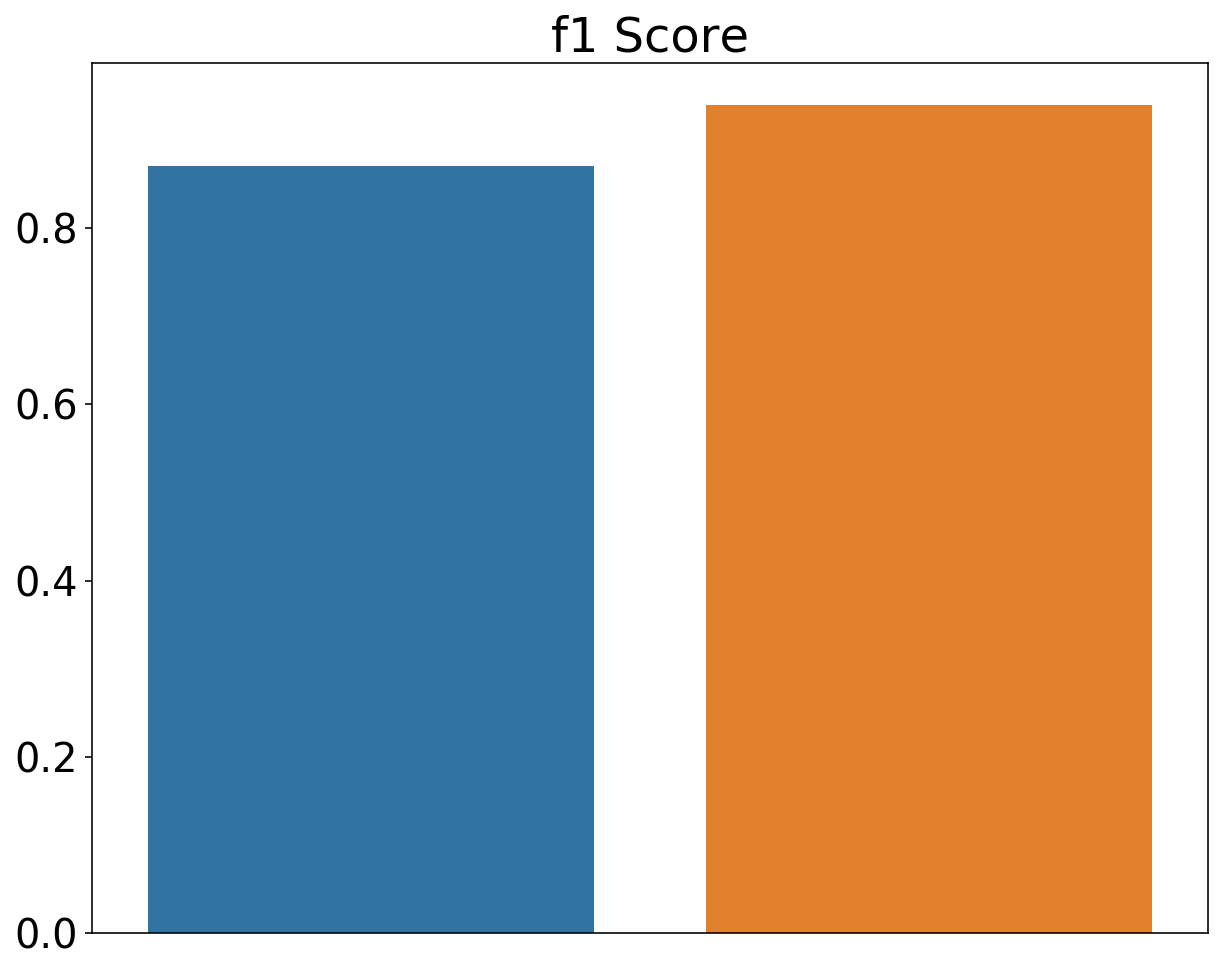

In [12]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
xs = ['LR','SGD']
ys = [.87, .94]
sns.barplot(xs,ys)
plt.xticks([])
plt.title('f1 Score')

### Mcnemar Test - Chi-squared test to see if there is truly a difference in above
There is.

In [24]:
type(y_pred_huber)

numpy.ndarray

In [31]:
import numpy as np
from mlxtend.evaluate import mcnemar_table

# The correct target (class) labels
y_target = y

# Class labels predicted by model 1
y_model1 = y_pred_lr

# Class labels predicted by model 2
y_model2 = y_pred_huber

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model1, 
                   y_model2=y_model2)

print(tb)

[[86479 20453]
 [ 8601  4298]]


In [32]:
from mlxtend.evaluate import mcnemar

chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

chi-squared: 4833.971260411648
p-value: 0.0
